# Alpha Sweep: Soup Weighting Analysis

This notebook evaluates 16 randomly sampled model pairs across all available epochs and
model IDs at mixing ratios $\alpha \in \{0.0, 0.1, 0.2, \ldots, 0.9, 1.0\}$ to show how
clean accuracy varies with the soup weighting. The goal is to justify using $\alpha = 0.5$
as a representative benchmark for model souping.

In [25]:
import os
import sys
os.chdir("/data/sghyselincks/too-salty")

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from evaluate import evaluate_model
from experiments import ModelManager
from salty.datasets import get_cifar100_loaders
from salty.utils import soup_models

plt.style.use('notebooks/style.mplstyle')

## 1. Configuration

In [29]:
# --- Configuration ---
N_PAIRS = 16                       # Number of random model pairs to evaluate
SEED = 42                          # Reproducible pair selection
ALPHAS = [round(a, 1) for a in np.arange(0.0, 1.1, 0.1)]  # 0.0 to 1.0
BATCH_SIZE = 1024
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESULT_PATH = "./analysis/alpha_sweep_results.csv"

print(f"Pairs: {N_PAIRS}")
print(f"Alphas: {ALPHAS}")
print(f"Device: {DEVICE}")

Pairs: 16
Alphas: [np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(1.0)]
Device: cuda


## 2. Load Models and Data

In [30]:
mm = ModelManager(device=torch.device(DEVICE))
_, _, test_loader = get_cifar100_loaders(batch_size=BATCH_SIZE)

# Generate all unique index pairs, then randomly sample 16 cross-model pairs
all_pairs = mm.get_index_pairs(unique=True)
all_pairs = [(a, b) for a, b in all_pairs if a != b]

rng = np.random.default_rng(SEED)
sampled_indices = rng.choice(len(all_pairs), size=N_PAIRS, replace=False)
pairs = [all_pairs[i] for i in sampled_indices]

print(f"Total unique cross-pairs available: {len(all_pairs)}")
print(f"Sampled {len(pairs)} pairs:")
for idx_a, idx_b in pairs:
    print(f"  {mm.get_key(idx_a)} + {mm.get_key(idx_b)}")

Total unique cross-pairs available: 1225
Sampled 16 pairs:
  210_3 + 240_2
  190_1 + 210_4
  190_1 + 230_3
  240_2 + 300_4
  240_1 + 240_3
  230_3 + 240_3
  220_2 + 250_3
  240_4 + 260_2
  250_1 + 280_3
  240_2 + 250_3
  210_3 + 220_3
  190_1 + 210_1
  260_1 + 280_2
  280_4 + 290_3
  240_4 + 280_1
  190_4 + 220_3


## 3. Run Alpha Sweep

For each of the 16 (model_A, model_B) pairs, evaluate the soup at every alpha.
Results are saved incrementally so the experiment can be resumed.

In [31]:
# --- Resume logic ---
computed_keys = set()
if os.path.exists(RESULT_PATH):
    df_existing = pd.read_csv(RESULT_PATH)
    computed_keys = set(
        df_existing.apply(
            lambda r: f"{r['key_a']}_{r['key_b']}_{r['alpha']:.1f}", axis=1
        )
    )
    print(f"Resuming: {len(computed_keys)} evaluations already done")

total = len(pairs) * len(ALPHAS)
done = len(computed_keys)
print(f"Total evaluations: {total}, remaining: {total - done}")

for idx_a, idx_b in pairs:
    key_a = mm.get_key(idx_a)
    key_b = mm.get_key(idx_b)
    model_a = mm[idx_a]
    model_b = mm[idx_b]

    for alpha in ALPHAS:
        run_key = f"{key_a}_{key_b}_{alpha:.1f}"
        if run_key in computed_keys:
            continue

        souped = soup_models(model_a, model_b, alpha=alpha)
        souped.to(DEVICE)
        acc, loss = evaluate_model(souped, test_loader, DEVICE)

        row = {
            "key_a": key_a,
            "key_b": key_b,
            "alpha": alpha,
            "clean_accuracy": acc,
            "clean_loss": loss,
        }
        df_row = pd.DataFrame([row])
        write_header = not os.path.exists(RESULT_PATH)
        df_row.to_csv(RESULT_PATH, mode="a", header=write_header, index=False)
        computed_keys.add(run_key)

        done += 1
        print(f"[{done}/{total}] {key_a} + {key_b}  alpha={alpha:.1f}  acc={acc:.2f}%")

        del souped
        torch.cuda.empty_cache()

    del model_a, model_b
    torch.cuda.empty_cache()

print("Alpha sweep complete.")

Total evaluations: 176, remaining: 176
Loading checkpoint from models/soup_models/epoch_210_model_3.pt
Loading checkpoint from models/soup_models/epoch_240_model_2.pt


[1/176] 210_3 + 240_2  alpha=0.0  acc=79.05%


[2/176] 210_3 + 240_2  alpha=0.1  acc=79.33%


[3/176] 210_3 + 240_2  alpha=0.2  acc=79.64%


[4/176] 210_3 + 240_2  alpha=0.3  acc=79.79%


[5/176] 210_3 + 240_2  alpha=0.4  acc=79.94%


[6/176] 210_3 + 240_2  alpha=0.5  acc=79.94%


[7/176] 210_3 + 240_2  alpha=0.6  acc=80.02%


[8/176] 210_3 + 240_2  alpha=0.7  acc=80.04%


[9/176] 210_3 + 240_2  alpha=0.8  acc=79.94%


[10/176] 210_3 + 240_2  alpha=0.9  acc=79.77%


[11/176] 210_3 + 240_2  alpha=1.0  acc=79.68%
Loading checkpoint from models/soup_models/epoch_190_model_1.pt
Loading checkpoint from models/soup_models/epoch_210_model_4.pt


[12/176] 190_1 + 210_4  alpha=0.0  acc=78.98%


[13/176] 190_1 + 210_4  alpha=0.1  acc=75.25%


[14/176] 190_1 + 210_4  alpha=0.2  acc=65.56%


[15/176] 190_1 + 210_4  alpha=0.3  acc=52.93%


[16/176] 190_1 + 210_4  alpha=0.4  acc=44.68%


[17/176] 190_1 + 210_4  alpha=0.5  acc=43.80%


[18/176] 190_1 + 210_4  alpha=0.6  acc=49.46%


[19/176] 190_1 + 210_4  alpha=0.7  acc=59.65%


[20/176] 190_1 + 210_4  alpha=0.8  acc=70.64%


[21/176] 190_1 + 210_4  alpha=0.9  acc=76.89%


[22/176] 190_1 + 210_4  alpha=1.0  acc=78.53%
Loading checkpoint from models/soup_models/epoch_190_model_1.pt
Loading checkpoint from models/soup_models/epoch_230_model_3.pt


[23/176] 190_1 + 230_3  alpha=0.0  acc=79.31%


[24/176] 190_1 + 230_3  alpha=0.1  acc=22.22%


[25/176] 190_1 + 230_3  alpha=0.2  acc=4.38%


[26/176] 190_1 + 230_3  alpha=0.3  acc=3.26%


[27/176] 190_1 + 230_3  alpha=0.4  acc=3.01%


[28/176] 190_1 + 230_3  alpha=0.5  acc=3.56%


[29/176] 190_1 + 230_3  alpha=0.6  acc=5.71%


[30/176] 190_1 + 230_3  alpha=0.7  acc=15.94%


[31/176] 190_1 + 230_3  alpha=0.8  acc=45.71%


[32/176] 190_1 + 230_3  alpha=0.9  acc=72.43%


[33/176] 190_1 + 230_3  alpha=1.0  acc=78.53%
Loading checkpoint from models/soup_models/epoch_240_model_2.pt
Loading checkpoint from models/soup_models/epoch_300_model_4.pt


[34/176] 240_2 + 300_4  alpha=0.0  acc=79.24%


[35/176] 240_2 + 300_4  alpha=0.1  acc=79.25%


[36/176] 240_2 + 300_4  alpha=0.2  acc=79.21%


[37/176] 240_2 + 300_4  alpha=0.3  acc=79.33%


[38/176] 240_2 + 300_4  alpha=0.4  acc=79.40%


[39/176] 240_2 + 300_4  alpha=0.5  acc=79.29%


[40/176] 240_2 + 300_4  alpha=0.6  acc=79.26%


[41/176] 240_2 + 300_4  alpha=0.7  acc=79.21%


[42/176] 240_2 + 300_4  alpha=0.8  acc=79.16%


[43/176] 240_2 + 300_4  alpha=0.9  acc=79.08%


[44/176] 240_2 + 300_4  alpha=1.0  acc=79.05%
Loading checkpoint from models/soup_models/epoch_240_model_1.pt
Loading checkpoint from models/soup_models/epoch_240_model_3.pt


[45/176] 240_1 + 240_3  alpha=0.0  acc=78.48%


[46/176] 240_1 + 240_3  alpha=0.1  acc=35.23%


[47/176] 240_1 + 240_3  alpha=0.2  acc=8.96%


[48/176] 240_1 + 240_3  alpha=0.3  acc=6.37%


[49/176] 240_1 + 240_3  alpha=0.4  acc=7.09%


[50/176] 240_1 + 240_3  alpha=0.5  acc=10.68%


[51/176] 240_1 + 240_3  alpha=0.6  acc=21.91%


[52/176] 240_1 + 240_3  alpha=0.7  acc=43.13%


[53/176] 240_1 + 240_3  alpha=0.8  acc=64.85%


[54/176] 240_1 + 240_3  alpha=0.9  acc=75.80%


[55/176] 240_1 + 240_3  alpha=1.0  acc=78.21%
Loading checkpoint from models/soup_models/epoch_230_model_3.pt
Loading checkpoint from models/soup_models/epoch_240_model_3.pt


[56/176] 230_3 + 240_3  alpha=0.0  acc=78.48%


[57/176] 230_3 + 240_3  alpha=0.1  acc=78.89%


[58/176] 230_3 + 240_3  alpha=0.2  acc=78.92%


[59/176] 230_3 + 240_3  alpha=0.3  acc=79.18%


[60/176] 230_3 + 240_3  alpha=0.4  acc=79.40%


[61/176] 230_3 + 240_3  alpha=0.5  acc=79.67%


[62/176] 230_3 + 240_3  alpha=0.6  acc=79.69%


[63/176] 230_3 + 240_3  alpha=0.7  acc=79.71%


[64/176] 230_3 + 240_3  alpha=0.8  acc=79.71%


[65/176] 230_3 + 240_3  alpha=0.9  acc=79.64%


[66/176] 230_3 + 240_3  alpha=1.0  acc=79.31%
Loading checkpoint from models/soup_models/epoch_220_model_2.pt
Loading checkpoint from models/soup_models/epoch_250_model_3.pt


[67/176] 220_2 + 250_3  alpha=0.0  acc=79.10%


[68/176] 220_2 + 250_3  alpha=0.1  acc=79.45%


[69/176] 220_2 + 250_3  alpha=0.2  acc=79.57%


[70/176] 220_2 + 250_3  alpha=0.3  acc=79.59%


[71/176] 220_2 + 250_3  alpha=0.4  acc=79.76%


[72/176] 220_2 + 250_3  alpha=0.5  acc=79.78%


[73/176] 220_2 + 250_3  alpha=0.6  acc=79.79%


[74/176] 220_2 + 250_3  alpha=0.7  acc=79.72%


[75/176] 220_2 + 250_3  alpha=0.8  acc=79.65%


[76/176] 220_2 + 250_3  alpha=0.9  acc=79.31%


[77/176] 220_2 + 250_3  alpha=1.0  acc=78.96%
Loading checkpoint from models/soup_models/epoch_240_model_4.pt
Loading checkpoint from models/soup_models/epoch_260_model_2.pt


[78/176] 240_4 + 260_2  alpha=0.0  acc=79.07%


[79/176] 240_4 + 260_2  alpha=0.1  acc=78.97%


[80/176] 240_4 + 260_2  alpha=0.2  acc=78.98%


[81/176] 240_4 + 260_2  alpha=0.3  acc=78.89%


[82/176] 240_4 + 260_2  alpha=0.4  acc=78.76%


[83/176] 240_4 + 260_2  alpha=0.5  acc=78.86%


[84/176] 240_4 + 260_2  alpha=0.6  acc=78.89%


[85/176] 240_4 + 260_2  alpha=0.7  acc=79.01%


[86/176] 240_4 + 260_2  alpha=0.8  acc=79.01%


[87/176] 240_4 + 260_2  alpha=0.9  acc=78.95%


[88/176] 240_4 + 260_2  alpha=1.0  acc=78.86%
Loading checkpoint from models/soup_models/epoch_250_model_1.pt
Loading checkpoint from models/soup_models/epoch_280_model_3.pt


[89/176] 250_1 + 280_3  alpha=0.0  acc=79.15%


[90/176] 250_1 + 280_3  alpha=0.1  acc=61.14%


[91/176] 250_1 + 280_3  alpha=0.2  acc=33.84%


[92/176] 250_1 + 280_3  alpha=0.3  acc=24.20%


[93/176] 250_1 + 280_3  alpha=0.4  acc=25.59%


[94/176] 250_1 + 280_3  alpha=0.5  acc=33.55%


[95/176] 250_1 + 280_3  alpha=0.6  acc=47.00%


[96/176] 250_1 + 280_3  alpha=0.7  acc=61.43%


[97/176] 250_1 + 280_3  alpha=0.8  acc=71.73%


[98/176] 250_1 + 280_3  alpha=0.9  acc=77.19%


[99/176] 250_1 + 280_3  alpha=1.0  acc=78.45%
Loading checkpoint from models/soup_models/epoch_240_model_2.pt
Loading checkpoint from models/soup_models/epoch_250_model_3.pt


[100/176] 240_2 + 250_3  alpha=0.0  acc=79.10%


[101/176] 240_2 + 250_3  alpha=0.1  acc=79.33%


[102/176] 240_2 + 250_3  alpha=0.2  acc=79.40%


[103/176] 240_2 + 250_3  alpha=0.3  acc=79.33%


[104/176] 240_2 + 250_3  alpha=0.4  acc=79.45%


[105/176] 240_2 + 250_3  alpha=0.5  acc=79.34%


[106/176] 240_2 + 250_3  alpha=0.6  acc=79.28%


[107/176] 240_2 + 250_3  alpha=0.7  acc=79.26%


[108/176] 240_2 + 250_3  alpha=0.8  acc=79.15%


[109/176] 240_2 + 250_3  alpha=0.9  acc=79.08%


[110/176] 240_2 + 250_3  alpha=1.0  acc=79.05%
Loading checkpoint from models/soup_models/epoch_210_model_3.pt
Loading checkpoint from models/soup_models/epoch_220_model_3.pt


[111/176] 210_3 + 220_3  alpha=0.0  acc=79.10%


[112/176] 210_3 + 220_3  alpha=0.1  acc=79.38%


[113/176] 210_3 + 220_3  alpha=0.2  acc=79.76%


[114/176] 210_3 + 220_3  alpha=0.3  acc=79.84%


[115/176] 210_3 + 220_3  alpha=0.4  acc=79.99%


[116/176] 210_3 + 220_3  alpha=0.5  acc=80.19%


[117/176] 210_3 + 220_3  alpha=0.6  acc=80.14%


[118/176] 210_3 + 220_3  alpha=0.7  acc=80.04%


[119/176] 210_3 + 220_3  alpha=0.8  acc=79.96%


[120/176] 210_3 + 220_3  alpha=0.9  acc=79.75%


[121/176] 210_3 + 220_3  alpha=1.0  acc=79.68%
Loading checkpoint from models/soup_models/epoch_190_model_1.pt
Loading checkpoint from models/soup_models/epoch_210_model_1.pt


[122/176] 190_1 + 210_1  alpha=0.0  acc=78.82%


[123/176] 190_1 + 210_1  alpha=0.1  acc=76.47%


[124/176] 190_1 + 210_1  alpha=0.2  acc=68.69%


[125/176] 190_1 + 210_1  alpha=0.3  acc=57.22%


[126/176] 190_1 + 210_1  alpha=0.4  acc=47.26%


[127/176] 190_1 + 210_1  alpha=0.5  acc=43.72%


[128/176] 190_1 + 210_1  alpha=0.6  acc=47.88%


[129/176] 190_1 + 210_1  alpha=0.7  acc=57.29%


[130/176] 190_1 + 210_1  alpha=0.8  acc=68.79%


[131/176] 190_1 + 210_1  alpha=0.9  acc=76.84%


[132/176] 190_1 + 210_1  alpha=1.0  acc=78.53%
Loading checkpoint from models/soup_models/epoch_260_model_1.pt
Loading checkpoint from models/soup_models/epoch_280_model_2.pt


[133/176] 260_1 + 280_2  alpha=0.0  acc=79.36%


[134/176] 260_1 + 280_2  alpha=0.1  acc=79.51%


[135/176] 260_1 + 280_2  alpha=0.2  acc=79.69%


[136/176] 260_1 + 280_2  alpha=0.3  acc=79.65%


[137/176] 260_1 + 280_2  alpha=0.4  acc=79.65%


[138/176] 260_1 + 280_2  alpha=0.5  acc=79.62%


[139/176] 260_1 + 280_2  alpha=0.6  acc=79.41%


[140/176] 260_1 + 280_2  alpha=0.7  acc=79.31%


[141/176] 260_1 + 280_2  alpha=0.8  acc=79.05%


[142/176] 260_1 + 280_2  alpha=0.9  acc=78.60%


[143/176] 260_1 + 280_2  alpha=1.0  acc=78.10%
Loading checkpoint from models/soup_models/epoch_280_model_4.pt
Loading checkpoint from models/soup_models/epoch_290_model_3.pt


[144/176] 280_4 + 290_3  alpha=0.0  acc=79.08%


[145/176] 280_4 + 290_3  alpha=0.1  acc=79.08%


[146/176] 280_4 + 290_3  alpha=0.2  acc=79.20%


[147/176] 280_4 + 290_3  alpha=0.3  acc=79.20%


[148/176] 280_4 + 290_3  alpha=0.4  acc=79.31%


[149/176] 280_4 + 290_3  alpha=0.5  acc=79.47%


[150/176] 280_4 + 290_3  alpha=0.6  acc=79.42%


[151/176] 280_4 + 290_3  alpha=0.7  acc=79.49%


[152/176] 280_4 + 290_3  alpha=0.8  acc=79.42%


[153/176] 280_4 + 290_3  alpha=0.9  acc=79.44%


[154/176] 280_4 + 290_3  alpha=1.0  acc=79.41%
Loading checkpoint from models/soup_models/epoch_240_model_4.pt
Loading checkpoint from models/soup_models/epoch_280_model_1.pt


[155/176] 240_4 + 280_1  alpha=0.0  acc=79.31%


[156/176] 240_4 + 280_1  alpha=0.1  acc=79.37%


[157/176] 240_4 + 280_1  alpha=0.2  acc=79.31%


[158/176] 240_4 + 280_1  alpha=0.3  acc=79.27%


[159/176] 240_4 + 280_1  alpha=0.4  acc=79.17%


[160/176] 240_4 + 280_1  alpha=0.5  acc=79.05%


[161/176] 240_4 + 280_1  alpha=0.6  acc=79.04%


[162/176] 240_4 + 280_1  alpha=0.7  acc=79.06%


[163/176] 240_4 + 280_1  alpha=0.8  acc=79.02%


[164/176] 240_4 + 280_1  alpha=0.9  acc=78.95%


[165/176] 240_4 + 280_1  alpha=1.0  acc=78.86%
Loading checkpoint from models/soup_models/epoch_190_model_4.pt
Loading checkpoint from models/soup_models/epoch_220_model_3.pt


[166/176] 190_4 + 220_3  alpha=0.0  acc=79.10%


[167/176] 190_4 + 220_3  alpha=0.1  acc=76.66%


[168/176] 190_4 + 220_3  alpha=0.2  acc=71.73%


[169/176] 190_4 + 220_3  alpha=0.3  acc=67.80%


[170/176] 190_4 + 220_3  alpha=0.4  acc=66.94%


[171/176] 190_4 + 220_3  alpha=0.5  acc=68.38%


[172/176] 190_4 + 220_3  alpha=0.6  acc=71.53%


[173/176] 190_4 + 220_3  alpha=0.7  acc=74.43%


[174/176] 190_4 + 220_3  alpha=0.8  acc=76.84%


[175/176] 190_4 + 220_3  alpha=0.9  acc=78.50%


[176/176] 190_4 + 220_3  alpha=1.0  acc=78.91%
Alpha sweep complete.


## 4. Load Results

In [32]:
df = pd.read_csv(RESULT_PATH)
print(f"Loaded {len(df)} rows")
df.head(10)

Loaded 176 rows


,key_a,key_b,alpha,clean_accuracy,clean_loss
0,210_3,240_2,0.0,79.05,0.990362
1,210_3,240_2,0.1,79.33,0.976940
2,210_3,240_2,0.2,79.64,0.967483
3,210_3,240_2,0.3,79.79,0.960538
4,210_3,240_2,0.4,79.94,0.955442
5,210_3,240_2,0.5,79.94,0.952454
6,210_3,240_2,0.6,80.02,0.951813
7,210_3,240_2,0.7,80.04,0.953152
8,210_3,240_2,0.8,79.94,0.957031
9,210_3,240_2,0.9,79.77,0.964048


## 5. Visualisation — 4 x 4 Grid of Alpha vs Clean Accuracy

Each subplot shows one randomly sampled model pair. The x-axis is `alpha` (weight on
model A) and the y-axis is clean accuracy. A vertical dashed line marks alpha = 0.5.

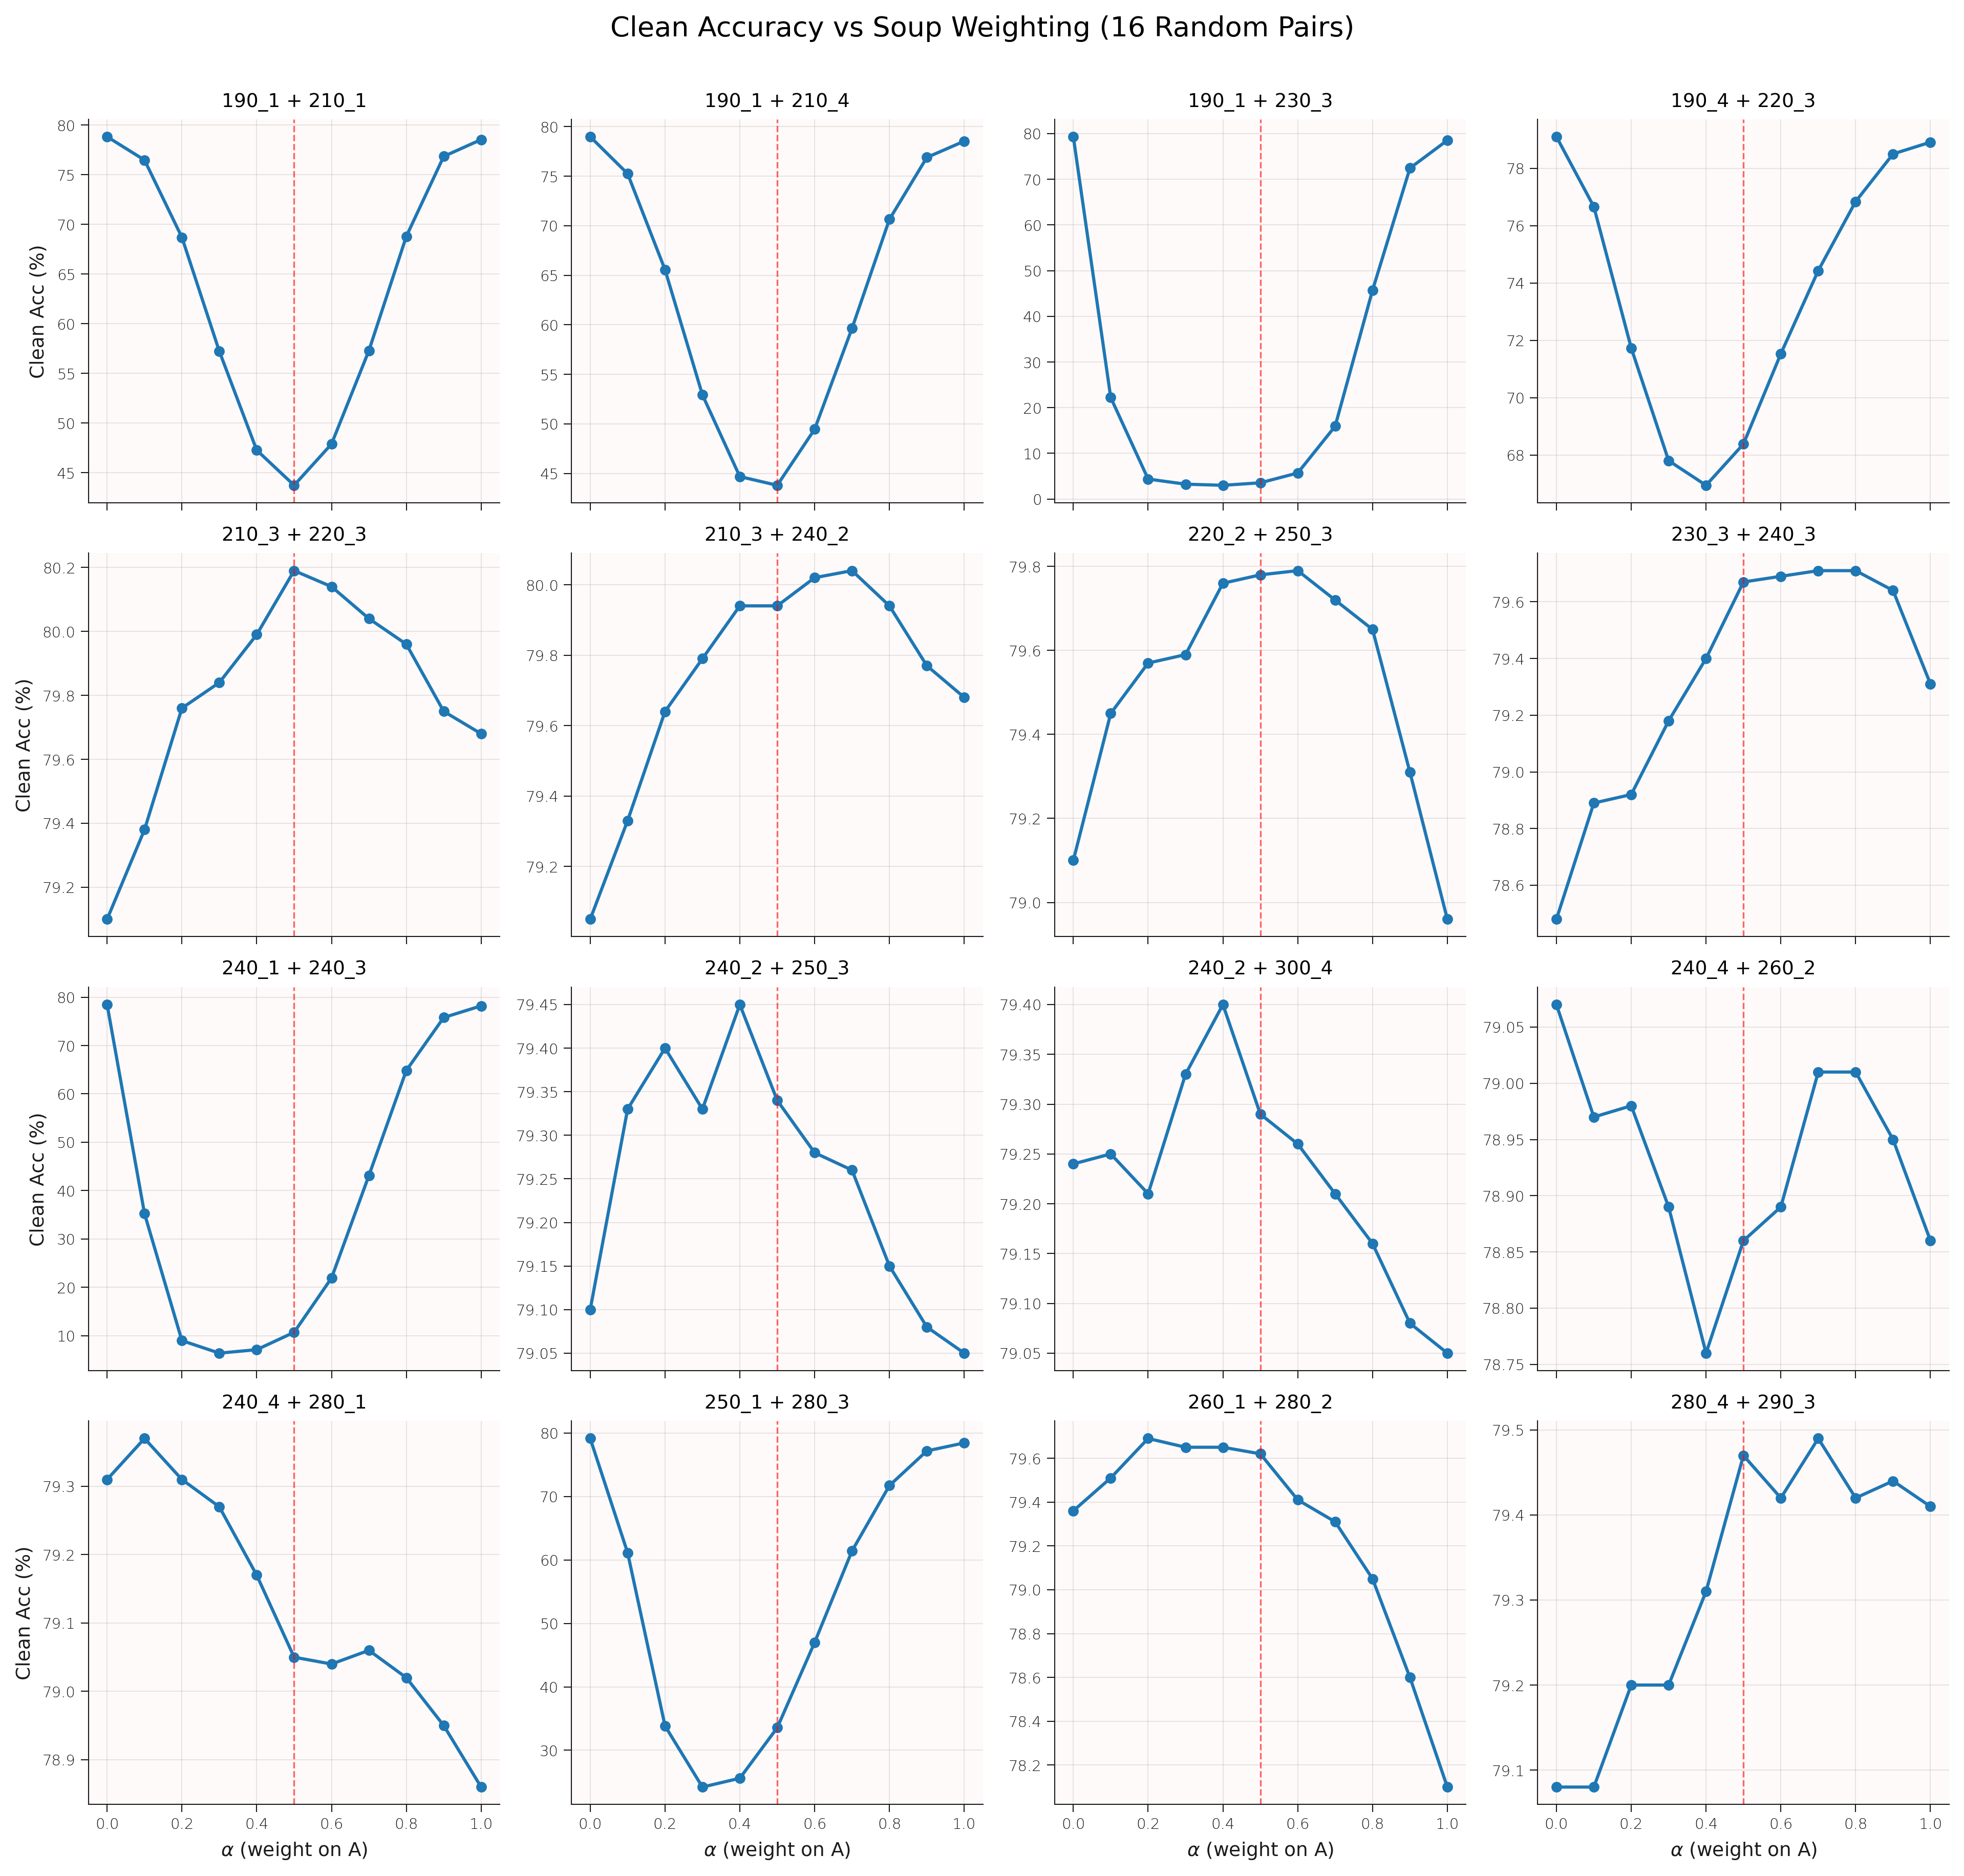

In [34]:
pair_list = list(df.groupby(["key_a", "key_b"]))
n = 4  # 4x4 grid

fig, axes = plt.subplots(n, n, figsize=(3.2 * n, 3 * n), sharex=True)

for idx, ((key_a, key_b), subset) in enumerate(pair_list[:16]):
    i, j = divmod(idx, n)
    ax = axes[i][j]
    subset = subset.sort_values("alpha")

    ax.plot(subset["alpha"], subset["clean_accuracy"], "o-", markersize=4)
    ax.axvline(0.5, color="red", linestyle="--", linewidth=0.8, alpha=0.6)
    ax.set_title(f"{key_a} + {key_b}", fontsize=9)

    if j == 0:
        ax.set_ylabel("Clean Acc (%)", fontsize=9)
    if i == n - 1:
        ax.set_xlabel(r"$\alpha$ (weight on A)", fontsize=9)

    ax.grid(True, alpha=0.3)

fig.suptitle("Clean Accuracy vs Soup Weighting (16 Random Pairs)", fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig("./report/figures/alpha_sweep_grid.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. Summary Table — Accuracy at $\alpha = 0.5$ vs Best Alpha

For each pair, compare the accuracy at the standard 0.5 mix with the best
accuracy found across all tested alphas.

In [ ]:
rows = []
for (key_a, key_b), subset in df.groupby(["key_a", "key_b"]):
    acc_at_05 = subset.loc[subset["alpha"].round(1) == 0.5, "clean_accuracy"].values
    best_row = subset.loc[subset["clean_accuracy"].idxmax()]
    rows.append({
        "Key A": key_a,
        "Key B": key_b,
        "Acc @ 0.5": acc_at_05[0] if len(acc_at_05) > 0 else np.nan,
        "Best Acc": best_row["clean_accuracy"],
        "Best Alpha": best_row["alpha"],
        "Diff (Best - 0.5)": best_row["clean_accuracy"] - (acc_at_05[0] if len(acc_at_05) > 0 else np.nan),
    })

df_summary = pd.DataFrame(rows)
print(f"Mean accuracy at alpha=0.5:  {df_summary['Acc @ 0.5'].mean():.2f}%")
print(f"Mean best accuracy:          {df_summary['Best Acc'].mean():.2f}%")
print(f"Mean gap (best - 0.5):       {df_summary['Diff (Best - 0.5)'].mean():.2f}%")
print()
df_summary

## 7. Distribution of Optimal Alpha Values

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.hist(df_summary["Best Alpha"], bins=np.arange(-0.05, 1.15, 0.1),
        edgecolor="black", alpha=0.7)
ax.axvline(0.5, color="red", linestyle="--", linewidth=1.2, label=r"$\alpha = 0.5$")
ax.set_xlabel(r"Best $\alpha$")
ax.set_ylabel("Count")
ax.set_title("Distribution of Optimal Alpha (16 Random Pairs)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../report/figures/alpha_sweep_best_dist.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Median best alpha: {df_summary['Best Alpha'].median():.1f}")
print(f"Mean gap best vs 0.5: {df_summary['Diff (Best - 0.5)'].mean():.2f}%")